In [237]:
import tensorflow as tf
from time import time
import numpy as np
import tensorflow.keras.backend as K
#import tensorflow_probability as tfp

from tensorflow.keras.layers import Layer, InputSpec,Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Conv1D,  Dense, Flatten, Reshape

from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
from sklearn.cluster import KMeans

from datasets import load_mnist, load_usps, load_mrec

#import tensorflow.eager as tfe
#tf.enable_eager_execution()

In [183]:
print(tf.executing_eagerly())
print(tf.__version__)
strategy = tf.distribute.MirroredStrategy()

print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))
print(GLOBAL_BATCH_SIZE)


W0716 18:36:18.565547 140591974237952 cross_device_ops.py:1111] Not all devices in `tf.distribute.Strategy` are visible to TensorFlow.


True
2.0.0-alpha0
Number of devices: 1


NameError: name 'GLOBAL_BATCH_SIZE' is not defined

In [3]:
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))

hello, [[4.]]


In [4]:
import metrics

def printMetrics(aName,yy,_loss):
        if yHid is not None:
                    acc = np.round(metrics.acc(yHid, yy), 5)
                    nmi = np.round(metrics.nmi(yHid, yy), 5)
                    ari = np.round(metrics.ari(yHid, yy), 5)
                    loss = np.round(_loss, 7)
                    #logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, L=_loss[0], Lc=_loss[1], Lr=_loss[2])
                    #logwriter.writerow(logdict)
                    # print('Iter', ite, ': Acc', acc, ', nmi', nmi, ', ari', ari, '; loss=', loss,'  delta=',delta_label)

                    print(aName,'acc = %.4f, nmi = %.4f, ari = %.4f' % (acc,nmi,ari),';  loss=',_loss)


In [7]:
# load dataset
Ndataset='mnist-test'
Nclusters=16
Nsave_dir='temp'
Ngamma=0.1
Ntol=0.001

In [8]:
from datasets import load_mnist, load_usps, load_mrec
if Ndataset == 'mnist':
    xData, yHid = load_mnist()
elif Ndataset == 'usps':
    xData, yHid = load_usps('data/usps')
elif Ndataset == 'mrec':
    xData, YY = load_mrec()
elif Ndataset == 'mnist-test':
    xData, yHid = load_mnist()
    xData, yHid = xData[60000:], yHid[60000:]

MNIST: (70000, 28, 28, 1)


In [97]:
def oneHot(y):
        e = np.zeros(10)
        e[y] = 1
        return e
train_Y10 = np.array([oneHot(y) for y in yHid])
train_Y10.shape
   

(10000, 10)

In [98]:
tdataset = tf.data.Dataset.from_tensor_slices((xData, train_Y10))
#test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

In [10]:
class DataLoader():
    def __init__(self):
        #print("__init__")
        # the data, shuffled and split between train and test sets
        from tensorflow.keras.datasets import mnist
        (train_x, train_y), (test_x, test_y) = mnist.load_data()
        
        
        
        #x = x_train.reshape(-1, 784).astype('float32')
        train_x = train_x/255.
        test_x=test_x/255.

        #with gzip.open('data/mnist.pkl.gz', 'rb') as f:
        #          train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    
        # with open("../input/mnist.pkl/mnist.pkl",mode="rb") as f:
        #          tr_d, va_d, te_d = pickle.load(f,encoding="bytes")
        #train_x = tr_d[0]
        #train_y = tr_d[1]
        self.train_x = np.array([np.reshape(X,(784)) for X in train_x]) 
        self.train_y = np.array([self.oneHot(y) for y in train_y])

            
        #    validation_x = va_d[0]
        #    validation_y = va_d[1]
        #    self.validation_x = np.array([np.reshape(X,(784)) for X in validation_x])
        #    self.validation_y = np.array([self.oneHot(y) for y in validation_y])
            
        #test_x = te_d[0]
        #test_y = te_d[1]
        self.test_x = np.array([np.reshape(X,(784)) for X in test_x])
        self.test_y = np.array([self.oneHot(y) for y in test_y])
        print('trainx',self.train_x.shape)
        print('trainy',self.train_y.shape)

    def oneHot(self,y):
        e = np.zeros(10)
        e[y] = 1
        return e
    
    def get_batch(self, batch_size):
        index = np.random.randint(0,len(self.train_x),batch_size)
        #print(index)
        print(type(self.train_x))
        return self.train_x[index,:],self.train_y[index]
    
    def getTestData(self):
        return self.test_x,self.test_y
  

    def get_batch_test(self, batch_size):
        index = np.random.randint(0,len(self.test_x),batch_size)
        #print(index)
        #print(type(self.train_x))
        return self.test_x[index],self.test_y[index]

In [11]:
#xdataset = x.shuffle(1000).batch(32)
#dataset = DataLoader()

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self,     input_shape=(28, 28, 1), filters=[32, 64, 128, 10]):
        super(Encoder, self).__init__()
        #self.w='name'
        #self.ishape=input_shape
        self.filters=filters
        #self.pad3
        # model = Sequential()
        if input_shape[0] % 8 == 0:
            pad3 = 'same'
        else:
            pad3 = 'valid'
            
        self.conv0= Conv2D(self.filters[0], 5, strides=(2,2), padding='same', activation='relu', name='conv0', input_shape=input_shape)
        self.conv1= Conv2D(self.filters[1], 5, strides=(2,2), padding='same', activation='relu', name='conv1')
        self.conv2= Conv2D(self.filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv2')
        self.flat= Flatten()
        self.emb=Dense(units=self.filters[3], name='embedding')
         
               
    def call(self, x, training=True):
        
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flat(x)
        return self.emb(x)
    
         
   

In [126]:
class Decoder(tf.keras.Model):
     def __init__(self,   flatten=(10,) ,  output_shape=(28,28,1), filters=[32, 64, 128, 10]):
        super(Decoder, self).__init__()
        if output_shape[0] % 8 == 0:
            pad3 = 'same'
        else:
            pad3 = 'valid'
        #self.ishape=input_shape
        self.filters=filters
      
        self.dense1=Dense(units=self.filters[2]*int(output_shape[0]/8)*int(output_shape[1]/8),input_shape=flatten , activation='relu')

        self.resh1=Reshape((int(output_shape[0]/8), int(output_shape[1]/8), filters[2]))
        self.deconv2=Conv2DTranspose(self.filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv2')

        self.deconv1=Conv2DTranspose(self.filters[0], 5, strides=(2,2), padding='same', activation='relu', name='deconv1')
        self.deconv0=Conv2DTranspose(output_shape[2], 5, strides=(2,2), padding='same', name='deconv0')
    
     def call(self, x, training=True):
        x = self.dense1(x)
        
        x = self.resh1(x)
     
        x = self.deconv2(x)
        x = self.deconv1(x)
        x = self.deconv0(x)       
        return x 

In [127]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters,n_dim, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.n_dim=n_dim
        self.alpha = alpha
        self.initial_weights = weights
        #self.input_spec = InputSpec(ndim=2)
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, n_dim))
       
      
        print('initLC')

 

    def build(self, input_shape):
        print('buildlc', input_shape)
        assert len(input_shape) == 2
        
        self.clusters = self.add_weight('clusters',(self.n_clusters, self.n_dim),trainable=True, initializer='glorot_uniform')
        #input_dim = input_shape[1]
        #self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True
        super(ClusteringLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    

In [231]:
#https://stackoverflow.com/questions/56951218/how-to-calculate-the-gradient-of-the-kullback-leibler-divergence-of-two-tensorfl
class KLDLayer(Layer):

    def __init__(self, **kwargs):
        super(KLDLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mean_W = self.add_weight('mean_W',trainable=True)
        super(KLDLayer, self).build(input_shape)

    def call(self,x):
        self.kernel_dist = tfp.distributions.MultivariateNormalDiag(
            loc=self.mean_W,
            scale_diag=(1.,)
        )
        return tfp.distributions.kl_divergence(
            self.kernel_dist,
            tfp.distributions.MultivariateNormalDiag(
                loc=self.mean_W*0.,
                scale_diag=(1.,)
            )
        )


In [222]:
class ClusteringModel(tf.keras.Model):
   
    def __init__(self,     aClusters=10,aDim=10):
        super(ClusteringModel, self).__init__()
        #self.w='name'
        self.emb=ClusteringLayer(n_clusters=aClusters,n_dim=aDim, name='clustering')
         
               
    def call(self, x, training=True):
        
        return self.emb(x)
    
    def setWeights(self,aWeights):
        self.emb.set_weights(aWeights)
 

In [129]:
num_batches = 100
batch_size = 256
learning_rate = 0.001
nGamma=0.1

In [130]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
#checkpoint = tf.train.Checkpoint(myModel=model,optimizer=optimizer)
g_encoder = Encoder()
g_decoder = Decoder()
         

In [131]:
xclusters=10
#clustering_layer = ClusteringLayer(n_clusters, name='clustering')(hidden)


In [132]:
dataset = tdataset.batch(batch_size)

In [133]:
for images,labels in dataset.take(2):

    #images,labels = dataset.get_batch(3)
    print(images.shape,labels.shape)
    #print("Logits: ", g_encoder(images[0:1]).numpy())



(256, 28, 28, 1) (256, 10)
(256, 28, 28, 1) (256, 10)


In [205]:
# The loss function to be optimized
def loss_mse( inputs, targets):
    #error = inputs - targets
    #sq=tf.square(error)
    sq=tf.keras.losses.MSE(inputs,targets)

    #return tf.compute_average_loss(   sq,        global_batch_size=GLOBAL_BATCH_SIZE)
    return tf.reduce_mean(sq)

In [206]:
def loss_kld(inputs,pred):
    _nn=tf.keras.losses.KLD( inputs,pred)
    return tf.reduce_mean(_nn)

In [207]:
def loss_sm( inputs, y):
    return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          logits=y, labels=inputs))

In [208]:
def train(model,X_train, Y_train, epochs):
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.1)
  
    for i in range(epochs):
        with tf.GradientTape() as tape:
            curr_loss = loss(model,X_train, Y_train)
        grads = tape.gradient( curr_loss, model.variables )
        optimizer.apply_gradients(zip(grads, model.variables),        global_step=tf.train.get_or_create_global_step())
    
    print("Loss at step {:d}: {:.3f}".format(i, loss(model, X_train , Y_train)))
    
print('d')

d


In [173]:
def classification_train():
    #start = time.time()
    loss = 0
    xoptimizer = tf.optimizers.Adam()

    for (batch, (x, labels)) in enumerate(dataset.take(-1)):
        if batch % 10 == 0:
             print('.',end='')
        #    print('Batch {} loss{:.3f}'.format(batch,loss) )
    
        loss = 0
        with tf.GradientTape() as tape:
            g_encoder.trainable = True
            z = g_encoder(x, training=True)
            #x_hat = g_decoder(z, training=True)
            loss = loss_sm(labels, z)
                       
        variables = g_encoder.trainable_variables
        #for  v in variables:
        #    print ("batch: ", v.name,'  ',v.shape)
        #print('nam:',g_encoder.trainable_variables.shape)
        #print('var:',variables)
        gradients = tape.gradient(loss, variables)
        
        xoptimizer.apply_gradients(zip(gradients, variables))
    return loss


In [174]:
EPOCHS = 6

for epoch in range(EPOCHS):
    ls=classification_train()
    print('Epoch {}  Loss {:.4f}'.format(epoch + 1,ls.numpy()))
    nn=g_encoder.predict(xData)
    nnp=nn.argmax(1)
    
    printMetrics('pre: ',nnp,ls)
  

....Epoch 1  Loss 0.0180
pre:  acc = 0.9525, nmi = 0.8870, ari = 0.8979 ;  loss= tf.Tensor(0.018010827, shape=(), dtype=float32)
....Epoch 2  Loss 0.0008
pre:  acc = 0.9791, nmi = 0.9445, ari = 0.9542 ;  loss= tf.Tensor(0.00084503414, shape=(), dtype=float32)
....Epoch 3  Loss 0.0003
pre:  acc = 0.9869, nmi = 0.9637, ari = 0.9712 ;  loss= tf.Tensor(0.00034566384, shape=(), dtype=float32)
....Epoch 4  Loss 0.0002
pre:  acc = 0.9899, nmi = 0.9717, ari = 0.9778 ;  loss= tf.Tensor(0.00015162281, shape=(), dtype=float32)
....Epoch 5  Loss 0.0001
pre:  acc = 0.9907, nmi = 0.9735, ari = 0.9795 ;  loss= tf.Tensor(7.212526e-05, shape=(), dtype=float32)
....Epoch 6  Loss 0.0000
pre:  acc = 0.9914, nmi = 0.9757, ari = 0.9806 ;  loss= tf.Tensor(2.4859657e-05, shape=(), dtype=float32)


In [175]:
nn=g_encoder.predict(xData)
print(nn[1],train_Y10[1])    

[ -9.047852   -2.4791203  16.472572   -6.0599923 -20.862007  -13.150835
  -3.2002225 -18.769917   -2.4611874 -25.569584 ] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [209]:
def pre_train():
    #start = time.time()
    loss = 0
    xoptimizer = tf.optimizers.Adam()
    
    for (batch, (x, labels)) in enumerate(dataset.take(-1)):
        #if batch % 10 == 0:
        #print('mse',x.shape)
                 
        #     print('.',end='')
        #    print('Batch {} loss{:.3f}'.format(batch,loss) )
    
        loss = 0
        with tf.GradientTape() as tape:
            g_encoder.trainable = True
            g_decoder.trainable = True
            z = g_encoder(x, training=True)
            x_hat = g_decoder(z, training=True)
            loss = loss_mse(x, x_hat)
            #print('mse',x.shape, loss.numpy())
                  
        #for  v in variables:
        #    print ("batch: ", v.name,'  ',v.shape)
        #print('nam:',g_encoder.trainable_variables.shape)
        #print('var:',variables)
        variables = g_encoder.trainable_variables + g_decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        
        xoptimizer.apply_gradients(zip(gradients, variables))
        #xoptimizer.minimize(loss,variables)
    return loss
                  

In [210]:
EPOCHS = 6

for epoch in range(EPOCHS):
    ls=pre_train()
    print('Epoch {}  Loss {:.4f}'.format(epoch + 1,ls.numpy()))
    nn=g_encoder.predict(xData)
    nnp=nn.argmax(1)
    
    printMetrics('pre: ',nnp,ls)
  
    #print('nam:',g_encoder.trainable_variables)
    
        
    ##variablesx = [v.name for v in g_encoder.trainable_variables]
    #print('names',variable_names)
    #values = sess.run(variables_names)
    #for  v in g_encoder.trainable_variables:
    #    print ("Variable: ", v.name,'  ',v.shape)
        #print ("Shape: ", v.shape)
    #    print v


mse (256, 28, 28, 1) 0.009252087
mse (256, 28, 28, 1) 0.014913804
mse (256, 28, 28, 1) 0.011826583
mse (256, 28, 28, 1) 0.013954412
mse (256, 28, 28, 1) 0.012982361
mse (256, 28, 28, 1) 0.013176286
mse (256, 28, 28, 1) 0.012904429
mse (256, 28, 28, 1) 0.012787782
mse (256, 28, 28, 1) 0.012925306
mse (256, 28, 28, 1) 0.012314297
mse (256, 28, 28, 1) 0.012462001
mse (256, 28, 28, 1) 0.012033183
mse (256, 28, 28, 1) 0.012018196
mse (256, 28, 28, 1) 0.012141665
mse (256, 28, 28, 1) 0.013362712
mse (256, 28, 28, 1) 0.012706832
mse (256, 28, 28, 1) 0.01245947
mse (256, 28, 28, 1) 0.012339722
mse (256, 28, 28, 1) 0.0119373165
mse (256, 28, 28, 1) 0.011489263
mse (256, 28, 28, 1) 0.011398189
mse (256, 28, 28, 1) 0.011284992
mse (256, 28, 28, 1) 0.014093808
mse (256, 28, 28, 1) 0.012978867
mse (256, 28, 28, 1) 0.012013935
mse (256, 28, 28, 1) 0.012767707
mse (256, 28, 28, 1) 0.01219884
mse (256, 28, 28, 1) 0.010725406
mse (256, 28, 28, 1) 0.011551959
mse (256, 28, 28, 1) 0.012148609
mse (256, 2

mse (256, 28, 28, 1) 0.014885792
mse (256, 28, 28, 1) 0.013504935
mse (256, 28, 28, 1) 0.010394651
mse (256, 28, 28, 1) 0.0143493535
mse (256, 28, 28, 1) 0.01186455
mse (256, 28, 28, 1) 0.016283672
mse (256, 28, 28, 1) 0.014485015
mse (16, 28, 28, 1) 0.011880574
Epoch 6  Loss 0.0119
pre:  acc = 0.4264, nmi = 0.3507, ari = 0.2076 ;  loss= tf.Tensor(0.011880574, shape=(), dtype=float32)


In [211]:
#yData = autoencoder.predict(xData)
import matplotlib.pyplot as plt
import random
zzz = g_encoder.predict(xData)
yHat=g_decoder.predict(zzz)

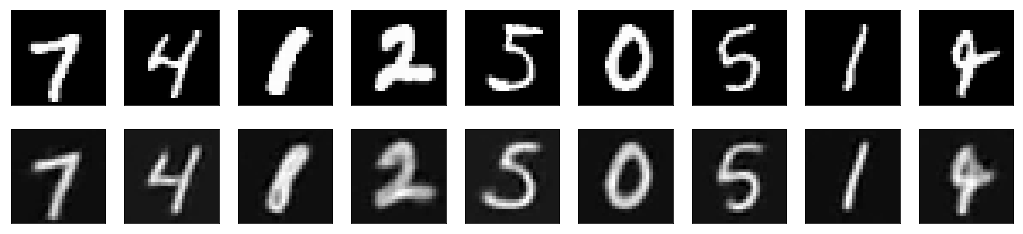

In [212]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    vv=random.randint(1,10000)
    plt.imshow(xData[vv].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #z = g_encoder.predict(xData[i])
    #yHat = g_decoder(z, training=True)
          

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(yHat[vv].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [213]:
print('Initializing cluster centers with k-means.')
kmeans = KMeans(n_clusters=xclusters, n_init=20)
y_pr = kmeans.fit_predict(g_encoder.predict(xData))
print('pred:',y_pr.shape)
    

Initializing cluster centers with k-means.
pred: (10000,)


In [214]:
print(kmeans.cluster_centers_)

[[  3.7153497    0.91084284  -0.21371841   5.1841664   -9.367039
   -3.3409793    0.13481784  -2.2584596    4.947014     2.7245884 ]
 [  5.52756      1.4020389    0.48630834   1.1042687   -3.5142682
    4.057763    -0.9080545    4.352916    -6.2820125    6.113641  ]
 [  2.26693      4.3559337   -1.6558882    3.1227243    2.0488894
   -3.8205929   -2.8306785    9.098958     1.8562992    0.29442883]
 [  3.1102843    2.138294    -8.169355     0.04561639  -1.2647371
    4.168779    -0.34173584  -4.2144003    8.476395     3.389319  ]
 [ 10.486285    -2.5292006   -1.9186387   -1.7270837   -0.7843191
   -1.787342    -2.9040074  -11.108117    -1.6634436    1.233525  ]
 [  5.654563    -1.1140316   -0.53909767  -3.0508392   -1.6572595
   -2.3467493   -3.014371     3.1685386    7.554686     5.034936  ]
 [  2.0027947   -2.6664755   -5.518729    -5.3685327   -1.4950584
   -5.38985      0.26576495   3.102964    -4.7899175    5.529003  ]
 [  7.230487    -3.0378077   -3.9186041    2.5775247    6.10007

In [223]:
g_clustering=ClusteringModel(xclusters,xclusters)
g_clustering.setWeights([kmeans.cluster_centers_])

initLC


In [239]:
gx = Input(shape=(10,))
gfx = ClusteringLayer(10,10)(gx)
CLmodel = Model(name='test_Clustering', inputs=[gx], outputs=[gfx])


initLC
buildlc (None, 10)


In [235]:
kx = Input(shape=(10,))
kfx = KLDLayer()(x)
KLmodel = Model(name='test_random', inputs=[kx], outputs=[kfx])


NameError: name 'tfp' is not defined

In [224]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T


In [225]:
nn=g_encoder.predict(xData)
#nn.shape
nnp = nn.argmax(1)
#na=zip(nnp,yHid)
print(nnp.shape)
print(yHid.shape)
printMetrics('Iter0',nnp,0.0)

(10000,)
(10000,)
Iter0 acc = 0.4264, nmi = 0.3507, ari = 0.2076 ;  loss= 0.0


In [226]:
nn=g_encoder.predict(xData)
nnp=nn.argmax(1)
    
p = target_distribution(nn)  # update the auxiliary target distribution p
ndataset = tf.data.Dataset.from_tensor_slices((xData, p)).batch(batch_size)
print(ndataset.take(1))
for images,labels in ndataset.take(1):

    #images,labels = dataset.get_batch(3)
    print('lab',labels[0])
    zz=g_encoder(images)
    print('zz',zz)
    z2=g_clustering(labels)
    print('g2',z2[0])
    print('kld',loss_kld(labels,z2))
    


<TakeDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>
lab tf.Tensor(
[-0.3545655   0.45527846  0.06518746  0.8057229   2.8872395   1.8693975
  0.04940075 -1.3665642  -3.2324367  -0.17865996], shape=(10,), dtype=float32)
zz tf.Tensor(
[[  5.685621     0.80314344   1.414061   ...   3.9176912   -7.3858223
    2.8651094 ]
 [ -2.6615272    7.0134077    7.343408   ...  -3.0310454   10.459287
   -3.202344  ]
 [  1.4785663    1.7134796   -1.8005834  ...   9.335108     1.6361098
   -2.4643269 ]
 ...
 [  2.947751     1.1345807  -11.101541   ...  -3.5898283    5.4802294
    0.5202478 ]
 [  2.7691753   -0.83559805   0.19727191 ...   4.4953995   -9.073815
    5.337539  ]
 [  2.4589562    2.6170359    1.1064471  ...  10.437503    -4.8946624
    3.3066757 ]], shape=(256, 10), dtype=float32)
buildlc (256, 10)
g2 tf.Tensor(
[0.07786503 0.13703214 0.10850964 0.08540079 0.082936   0.08479349
 0.10641936 0.14377011 0.09256916 0.08070423], shape=(10,), dtype=float32)
kld tf

In [283]:
def cluster_train():
    nn2=g_encoder.predict(xData)
    nn=g_clustering.predict(nn2)
    nnp=nn.argmax(1)
    
    p = target_distribution(nn)  # update the auxiliary target distribution p
    ndataset = tf.data.Dataset.from_tensor_slices((xData, p)).batch(batch_size)
    printMetrics('Iter ',nnp,0.1)
    #print('x',xData[0])
    #print('q',nn[0])
    #print('p',p.shape, p[0])
    loss = 0
    variables = g_encoder.variables + g_decoder.variables+ g_clustering.variables
    #variables = g_encoder.variables + g_decoder.variables+ CLmodel.variables
         
    for (batch, (x, labels)) in enumerate(ndataset.take(-1)):
        if batch % 10 == 0:
            nn=g_encoder.predict(xData)
    
            p = target_distribution(nn)  # update the auxiliary target distribution p
            yn=CLmodel(nn)
            _nn=tf.keras.losses.KLD( p,yn)
            print('nn',_nn)
        #     print('.',end='')
        #    print('Batch {} loss{:.3f}'.format(batch,loss) )
    
        
        #q, _ = self.model.predict(x, verbose=0)
        #p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
        #        self.y_pred = q.argmax(1)
   
        with tf.GradientTape() as tape:
            g_encoder.trainable = True
            g_decoder.trainable = True
            g_clustering.trainable =True
            z = g_encoder(x, training=True)
            #y_pred = tf.argmax(z,1)
            x_hat = g_decoder(z, training=True)
            y_hat=CLmodel(z)
            y_hat=g_clustering(z,training=True)
            #print('yhat',y_hat.numpy(),y_pred.shape, labels.shape)
            #id=batch * batch_size
            #pll=p[id:(id + batch_size)]
            lossmse = loss_mse(x, x_hat)
            losskld = loss_kld(labels,y_hat)   
            loss=lossmse+losskld*0.2
        
        if batch % 10 == 0:
            print('lossmse',lossmse.numpy(),':kld',losskld.numpy())
            #print('labe=',labels[0])
            #print('yhat',y_hat[0])
            #print('pll=',pll[0])
            #print('kld=',tf.keras.losses.KLD( pll[0],y_hat[0]))
            
                #print(labels)
      
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
    
    return loss
 

In [284]:
EPOCHS = 8

for epoch in range(EPOCHS):
    ls=cluster_train()
    print('Epoch {}  Loss {:.4f}'.format(epoch + 1,ls.numpy()))
             


Iter  acc = 0.6756, nmi = 0.6241, ari = 0.5151 ;  loss= 0.1
nn tf.Tensor([1.1618898 2.192871  1.989682  ... 1.609273  1.7562814 2.1360443], shape=(10000,), dtype=float32)
lossmse 0.01492223 :kld 0.19502407
nn tf.Tensor([10.54277    3.3808966  4.61855   ...  4.7920356  2.29875    2.1230388], shape=(10000,), dtype=float32)
lossmse 0.018878127 :kld 0.11098859
nn tf.Tensor([4.166155  2.272351  5.1356554 ... 3.8521295 8.705306  2.4652345], shape=(10000,), dtype=float32)
lossmse 0.018723648 :kld 0.09062822
nn tf.Tensor([2.248446  2.230135  1.7939208 ... 1.9252322 1.7949194 1.4408478], shape=(10000,), dtype=float32)
lossmse 0.020329613 :kld 0.050022505
Epoch 1  Loss 0.0212
Iter  acc = 0.7333, nmi = 0.6743, ari = 0.5820 ;  loss= 0.1
nn tf.Tensor([4.4221563 1.7271726 2.7153773 ... 2.9972315 1.5338426 1.0850186], shape=(10000,), dtype=float32)
lossmse 0.018276151 :kld 0.2294249
nn tf.Tensor([3.2003303 1.6080921 2.43248   ... 7.2629175 2.6519578 1.6636533], shape=(10000,), dtype=float32)
lossmse 

In [ ]:
def pre_train():
    #start = time.time()
    loss = 0
    for (batch, (x, labels)) in enumerate(dataset.take(40)):
        if batch % 10 == 0:
             print('.',end='')
        #    print('Batch {} loss{:.3f}'.format(batch,loss) )
    
        loss = 0
        with tf.GradientTape() as tape:
            g_encoder.trainable = True
            g_decoder.trainable = True
            z = g_encoder(x, training=True)
            x_hat = g_decoder(z, training=True)
            loss = loss_mse(x, x_hat)
                       
        variables = g_encoder.variables + g_decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
    return loss

In [ ]:
 # Generator Training
    #https://github.com/tensorflow/tensorflow/issues/23407
            with tf.GradientTape() as tape:

                # err_g_bce
                g_encoder.trainable = True
                g_decoder.trainable = True
                z = g_encoder(x, training=True)
                x_hat = g_decoder(z, training=True)
                bce_loss = tf.losses.sigmoid_cross_entropy(
                    multi_class_labels=tf.ones_like(disc_x_hat),
                    logits=disc_x_hat,  # G wants to generate reals so ones_like
                )

                l1_loss = tf.losses.absolute_difference(x, x_hat)
                # err_g_enc
                z_hat = encoder(x_hat, training=True)
                l2_loss = tf.losses.mean_squared_error(z, z_hat)

                gen_loss = 1* bce_loss + 50 * l1_loss + 1 * l2_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:

cae = CAE(input_shape, filters)
hidden = self.cae.get_layer(name='embedding').output
encoder = Model(inputs=self.cae.input, outputs=hidden)

# Define DCEC model
#    clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(hidden)
model = Model(inputs=cae.input,outputs=[cae.output])

self.cae.compile(optimizer=optimizer, loss='mse')
#from keras.callbacks import CSVLogger
#        csv_logger = CSVLogger(args.save_dir + '/pretrain_log.csv')

        # begin training
t0 = time()
#self.cae.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=[csv_logger])


In [ ]:
self.cae = CAE(input_shape, filters)
        hidden = self.cae.get_layer(name='embedding').output
        self.encoder = Model(inputs=self.cae.input, outputs=hidden)

        # Define DCEC model
        print('nn',self.n_clusters)
        clustering_layer = ClusteringLayer(n_clusters=self.n_clusters, name='clustering')(hidden)
        self.model = Model(inputs=self.cae.input,
                           outputs=[clustering_layer, self.cae.output])

    def pretrain(self, x, batch_size=256, epochs=50, optimizer='adam'):
        print('...Pretraining...')
        self.cae.compile(optimizer=optimizer, loss='mse')
        from tensorflow.keras.callbacks import CSVLogger
        csv_logger = CSVLogger(self.save_dir + '/pretrain_log.csv')

        # begin training
        t0 = time()
        self.cae.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=[csv_logger])
        print('Pretraining time: ', time() - t0)

In [ ]:
def train():
    optimizer= tf.train.AdamOptimizer()
    for epoch in range(3):
        for (batch, (images, labels)) in enumerate(dataset):
            train_step(images, labels)
        print ('Epoch {} finished'.format(epoch))